In [18]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

In [2]:
plt.style.use("ggplot")

* How many different cases are there, by department?

In [3]:
# case number by department
df.groupby("department").agg(count('case_id')).show()

+--------------------+--------------+
|          department|count(case_id)|
+--------------------+--------------+
|         Solid Waste|        279270|
|Animal Care Services|        116915|
|Trans & Cap Impro...|         96193|
|  Parks & Recreation|         19907|
|    Customer Service|          2849|
|        Metro Health|          5163|
|        City Council|            33|
|DSD/Code Enforcement|        321374|
+--------------------+--------------+



<AxesSubplot:ylabel='department'>

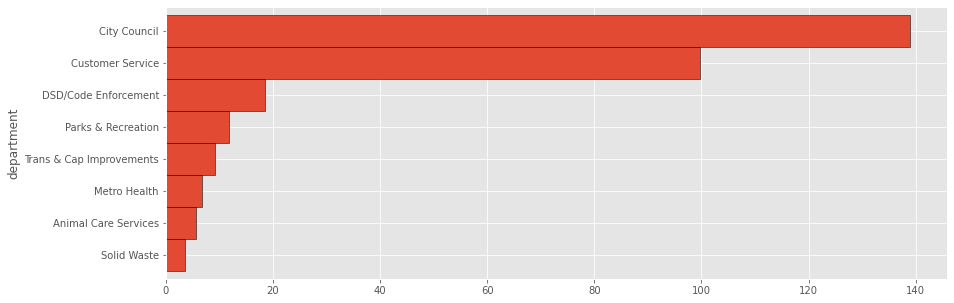

In [4]:
# Explore by case lifetime by dept to see who's more efficient
(
df.groupby("department").agg(mean('case_lifetime').alias('case_life'))
.toPandas()
.set_index('department')
.case_life.sort_values(ascending=True)
.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)


* Does the percentage of cases that are late vary by department?


In [5]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

Text(0.5, 1.0, 'Perc Late By Department')

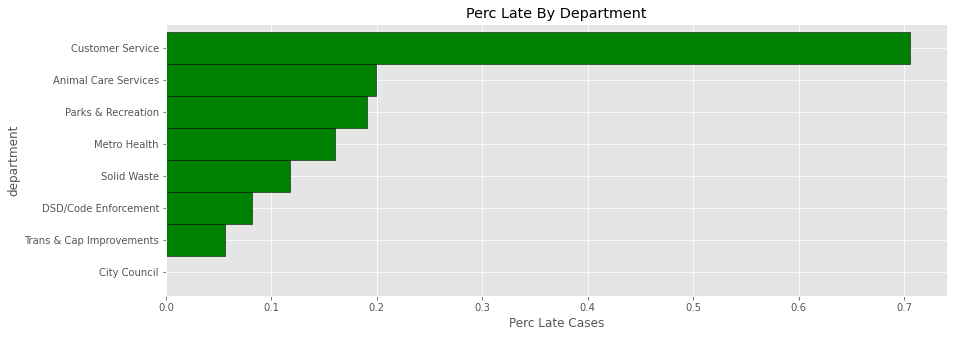

In [6]:
(   
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("perc_case_late"))
    .toPandas()
    .set_index("department")
    .perc_case_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Perc Late Cases")
plt.title("Perc Late By Department")

* On average, how late are the late cases by department?

Text(0.5, 1.0, 'Days Late by Department')

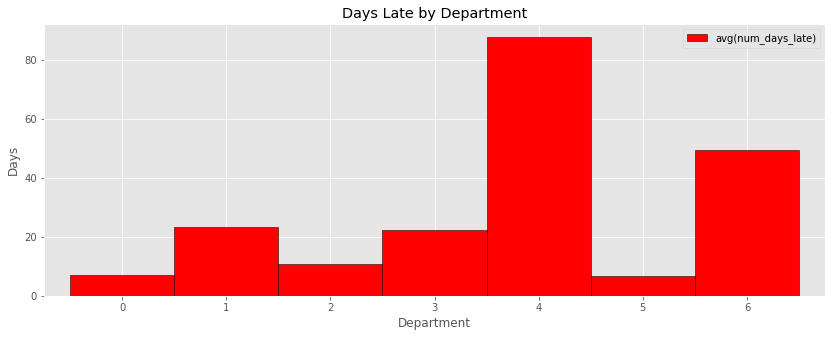

In [32]:
(df.where(df.case_late == 'true')
.groupby('department')
.agg(avg('num_days_late'))
.toPandas()
.plot.bar(width=1, edgecolor="black", figsize=(14, 5), color='red'))   
plt.xlabel("Department")
plt.xticks(rotation=0)
plt.ylabel("Days")
plt.title("Days Late by Department")

* What is the service type that is the most late? Just for Parks & Rec?

In [37]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



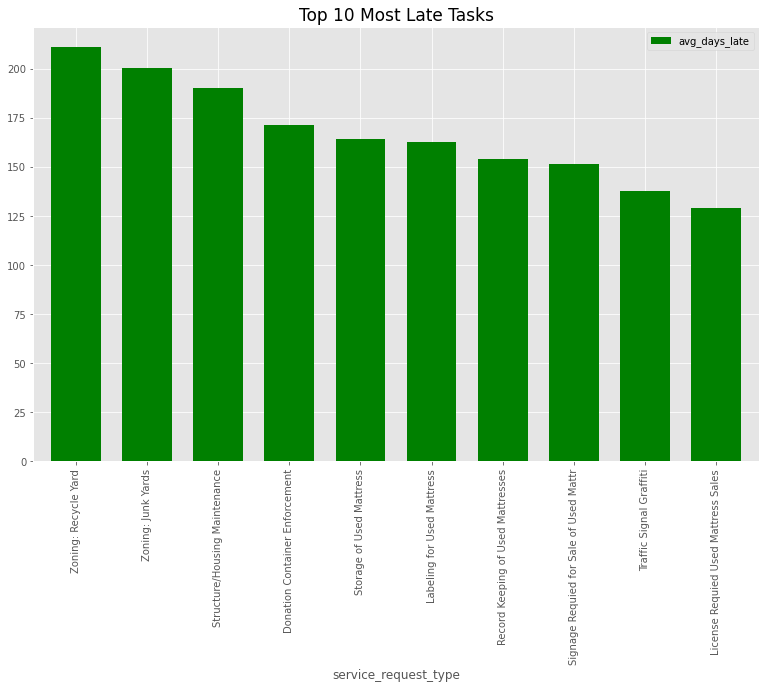

In [49]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(10)
    .plot.bar(figsize = (13,8), width = .7, color = 'green')
)
plt.xticks(rotation = 90)
plt.title('Top 10 Most Late Tasks', fontsize = 17)
plt.show()

In [39]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...|    76.87018194568|
|Major Park Improv...| 75.79450367282354|
|Reservation Assis...|       66.03116319|
|Park Building Mai...|59.367469802695666|
| Sportfield Lighting|51.480049793645534|
|          Electrical|42.951971658345116|
|        Tree Removal| 40.28404224560715|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253488|
+--------------------+------------------+
only showing top 10 rows



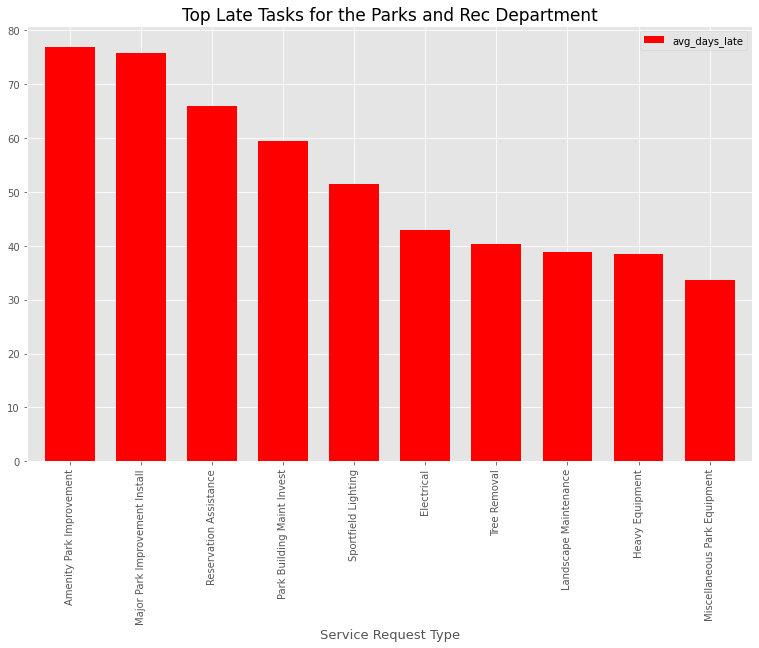

In [50]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(10)
    .plot.bar(figsize = (13,8), width = .7, color = 'red')
)
plt.xticks(rotation = 90)
plt.xlabel('Service Request Type', fontsize = 13)
plt.title('Top Late Tasks for the Parks and Rec Department', fontsize = 17)
plt.show()

* For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [56]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(5, truncate = False)
)

+--------------------------------+-----+
|service_request_type            |count|
+--------------------------------+-----+
|Overgrown Yard/Trash            |65895|
|Bandit Signs                    |32910|
|Front Or Side Yard Parking      |28794|
|Junk Vehicle On Private Property|21473|
|Alley-Way Maintenance           |20214|
+--------------------------------+-----+
only showing top 5 rows



In [64]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .plot.bar(figsize = (13,8), width = .7, color = 'red')
)

AttributeError: 'DataFrame' object has no attribute 'plot'

In [53]:
(
    df.filter(col('department') == 'Solid Waste')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(5, truncate = False)
)

+---------------------+-----+
|service_request_type |count|
+---------------------+-----+
|No Pickup            |86855|
|Damaged Cart         |30338|
|Cart Exchange Request|22024|
|Lost/Stolen Cart     |18731|
|Dead Animal - Dog    |16714|
+---------------------+-----+
only showing top 5 rows



In [54]:
(
    df.filter(col('department') == 'Parks & Recreation')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(5, truncate = False)
)

+----------------------------+-----+
|service_request_type        |count|
+----------------------------+-----+
|Carpentry                   |1944 |
|Plumbing                    |1782 |
|Heating and Air Conditioning|1459 |
|Playgrounds                 |1438 |
|Ballfields                  |1234 |
+----------------------------+-----+
only showing top 5 rows



* Does the number of service requests for the solid waste department vary by day of the week?

In [33]:
df_sw = (df.filter(df.department == "Solid Waste"))

In [34]:
df_sw.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127378           
 case_opened_date     | 2018-01-01 08:24:00  
 case_closed_date     | 2018-01-02 07:37:00  
 case_due_date        | 2018-01-03 08:24:00  
 case_late            | false                
 num_days_late        | -1.03287037          
 case_closed          | true                 
 service_request_type | Dead Animal - Cat    
 SLA_days             | 2.0                  
 case_status          | Closed               
 source_id            | 139344               
 request_address      | 7059  TIMBERCREEK... 
 council_district     | 006                  
 num_weeks_late       | -0.14755290999999998 
 zipcode              | 78227                
 case_age             | 219                  
 days_to_closed       | 1                    
 case_lifetime        | 1                    
 department           | Solid Waste          
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [35]:
req_daily = df_sw.select(
    "department",
    "case_id",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    dayofweek("case_opened_date").alias('day'))

req_daily.show(5)

+-----------+----------+----------------+---+
| department|   case_id|case_opened_date|day|
+-----------+----------+----------------+---+
|Solid Waste|1014127378|      2018-01-01|  2|
|Solid Waste|1014127411|      2018-01-01|  2|
|Solid Waste|1014127439|      2018-01-01|  2|
|Solid Waste|1014127442|      2018-01-01|  2|
|Solid Waste|1014127445|      2018-01-01|  2|
+-----------+----------+----------------+---+
only showing top 5 rows



In [36]:
cases_opened_by_day = (
    req_daily
    .groupby('day')
    .count()
    .na.drop()
    .sort('day')
    .toPandas()
    .set_index('day'))['count']

In [ ]:
cases_opened_by_day

In [ ]:
cases_opened_by_day.plot.bar(width=1, edgecolor="black", figsize=(14, 5), color='red')
plt.xlabel("Day of Week")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Solid Waste Cases Opened by Day")